# Hybrid Demucs from Colab

This supports the Demucs source separation model (https://github.com/facebookresearch/demucs/)
This is only for separation with pre-trained models, not training!

You can either upload files manually (slow) or link your Google Drive account.

논문: https://arxiv.org/pdf/1911.13254.pdf

arxiv: https://arxiv.org/abs/1911.13254


wav source file: https://www.ee.columbia.edu/~dpwe/sounds/music/

In [1]:
# Customize the following options!
model = "mdx_extra"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
two_stems = None   # only separate one stems from the rest, for instance
# two_stems = "vocals"

# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

in_path = 'input'
out_path = 'output'

In [2]:
import os


if not os.path.exists(in_path):
    os.mkdir(in_path)
    
if not os.path.exists(out_path):
    os.mkdir(out_path)

In [ ]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO

from google.colab import files

def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")


def from_upload():
    out_path = Path('separated')
    in_path = Path('tmp_in')

    if in_path.exists():
        rmtree(in_path)
    in_path.mkdir()

    if out_path.exists():
        rmtree(out_path)
    out_path.mkdir()

    uploaded = files.upload()
    for name, content in uploaded.items():
        (in_path / name).write_bytes(content)
    separate(in_path, out_path)


In [ ]:
# This can be quite slow, in particular the loading, and saving from GDrive. Please be patient!
# This is from google drive! Also, this will separate all the files inside the MyDrive/demucs folder,
# so when you are happy with the results, remove the songs from there.
separate()

Going to separate the files:
/content/drive/MyDrive/demucs/africa-toto.wav
With command:  python3 -m demucs.separate -o /content/drive/MyDrive/demucs_separated/ -n mdx_extra --mp3 --mp3-bitrate=320


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/e51eebcc-c1b80bdd.th" to /root/.cache/torch/hub/checkpoints/e51eebcc-c1b80bdd.th
100%|██████████| 160M/160M [00:03<00:00, 51.8MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/a1d90b5c-ae9d2452.th" to /root/.cache/torch/hub/checkpoints/a1d90b5c-ae9d2452.th
100%|██████████| 160M/160M [00:02<00:00, 62.9MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/5d2d6c55-db83574e.th" to /root/.cache/torch/hub/checkpoints/5d2d6c55-db83574e.th
100%|██████████| 160M/160M [00:01<00:00, 109MB/s]
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/cfa93e08-61801ae1.th" to /root/.cache/torch/hub/checkpoints/cfa93e08-61801ae1.th
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


Selected model is a bag of 4 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/drive/MyDrive/demucs_separated/mdx_extra
Separating track /content/drive/MyDrive/demucs/africa-toto.wav


100%|████████████████████████████████████████████████████████████████████████| 330.0/330.0 [00:09<00:00, 36.53seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 330.0/330.0 [00:08<00:00, 41.12seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 330.0/330.0 [00:07<00:00, 43.91seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 330.0/330.0 [00:07<00:00, 45.05seconds/s]


#- check wav spectrogram (bass stem)

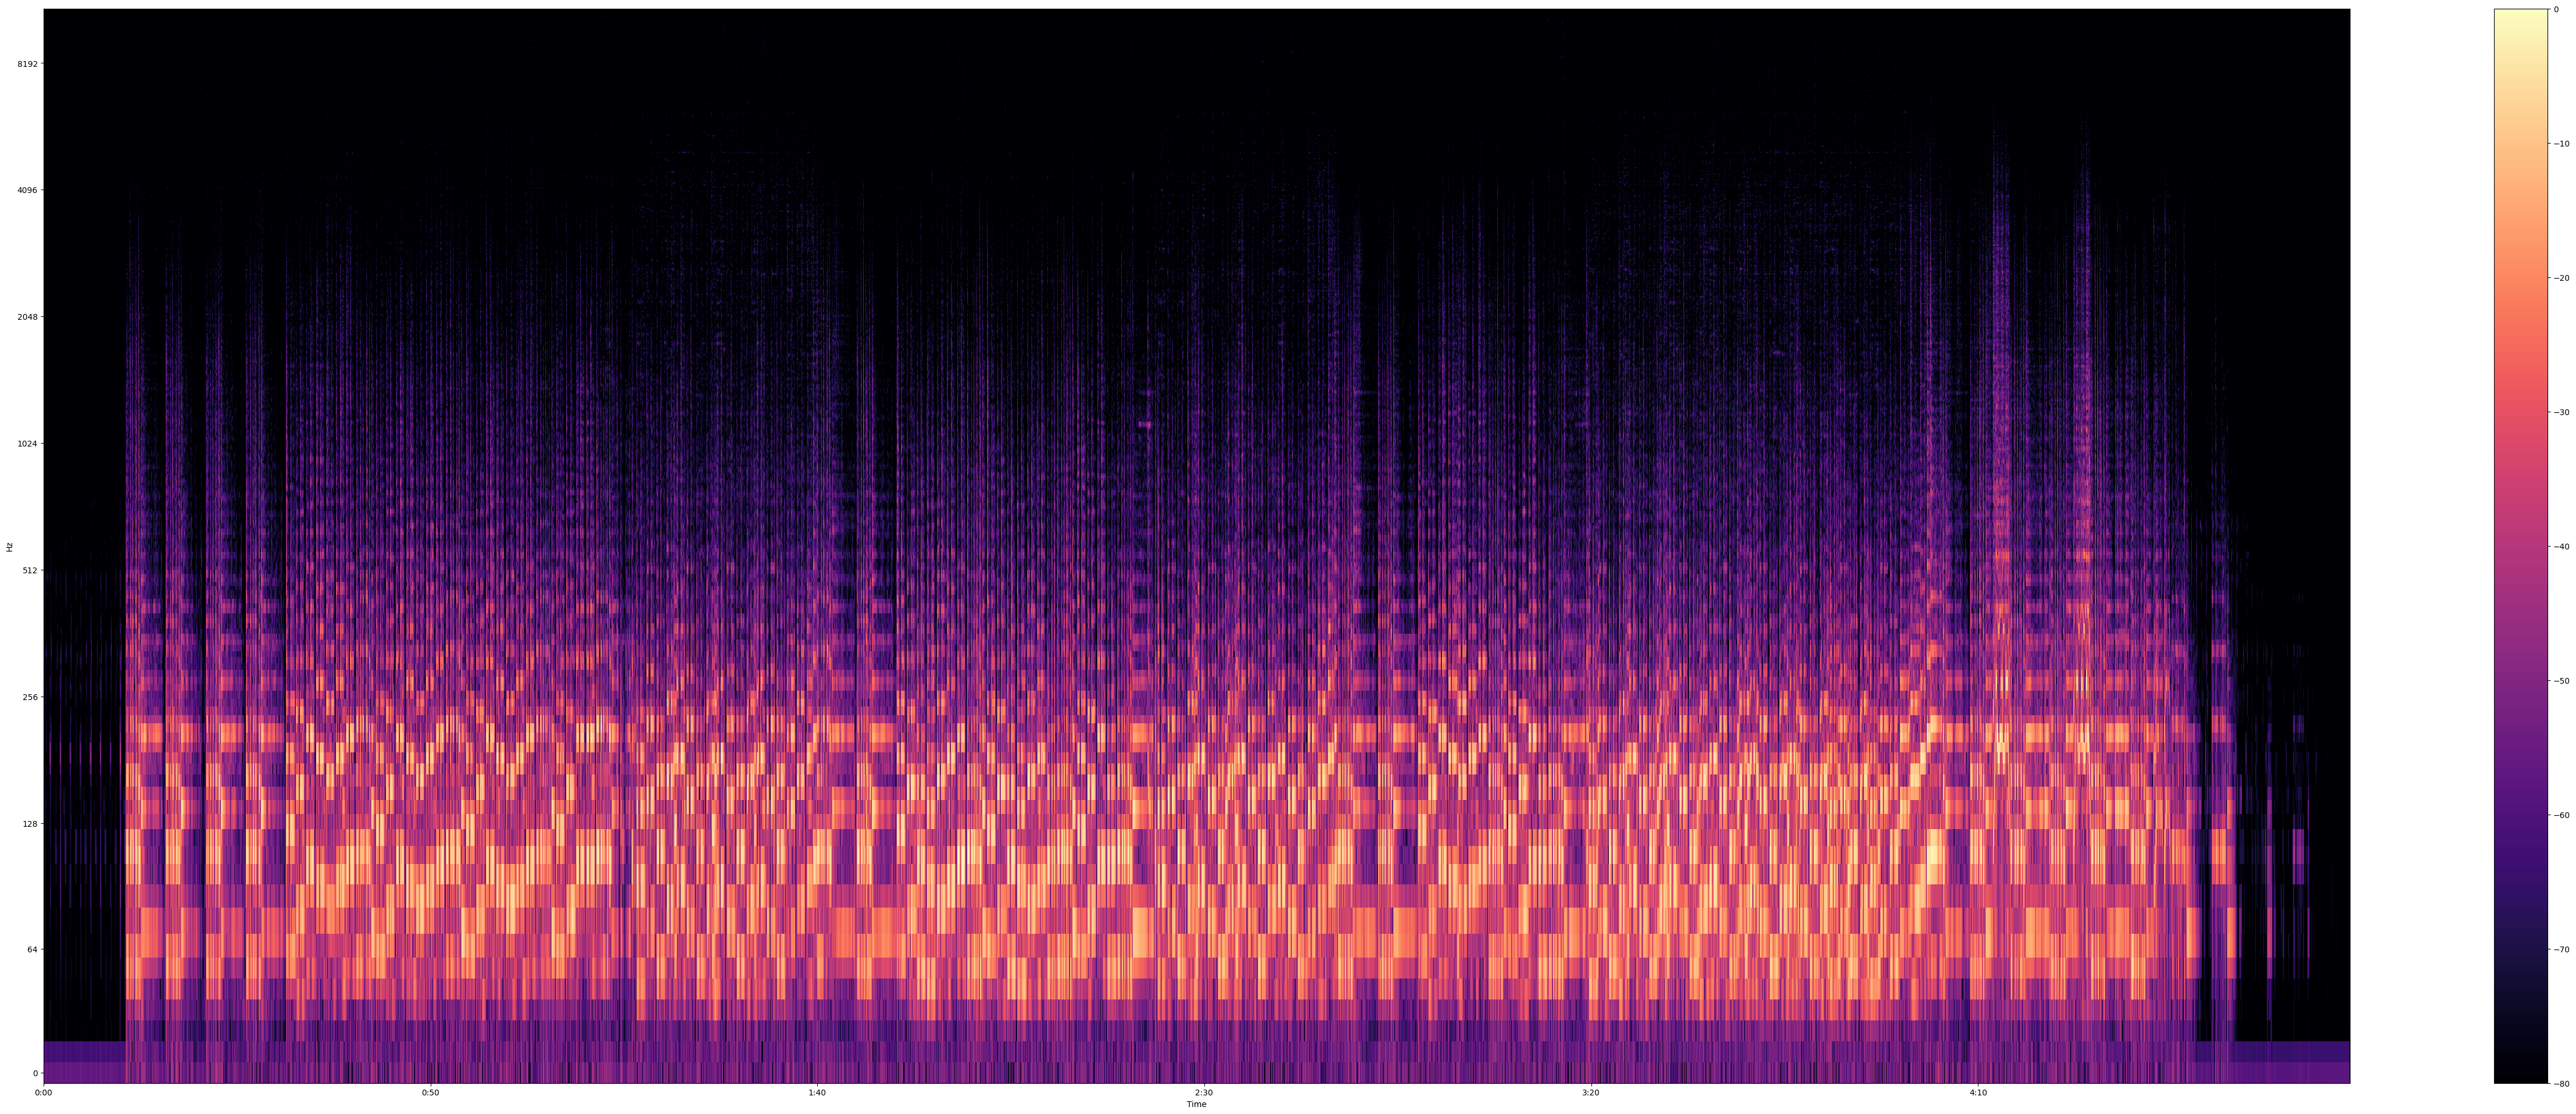

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display


y, sr = librosa.load("/content/drive/MyDrive/demucs_separated/mdx_extra/africa-toto/bass.mp3")
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(64, 24))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

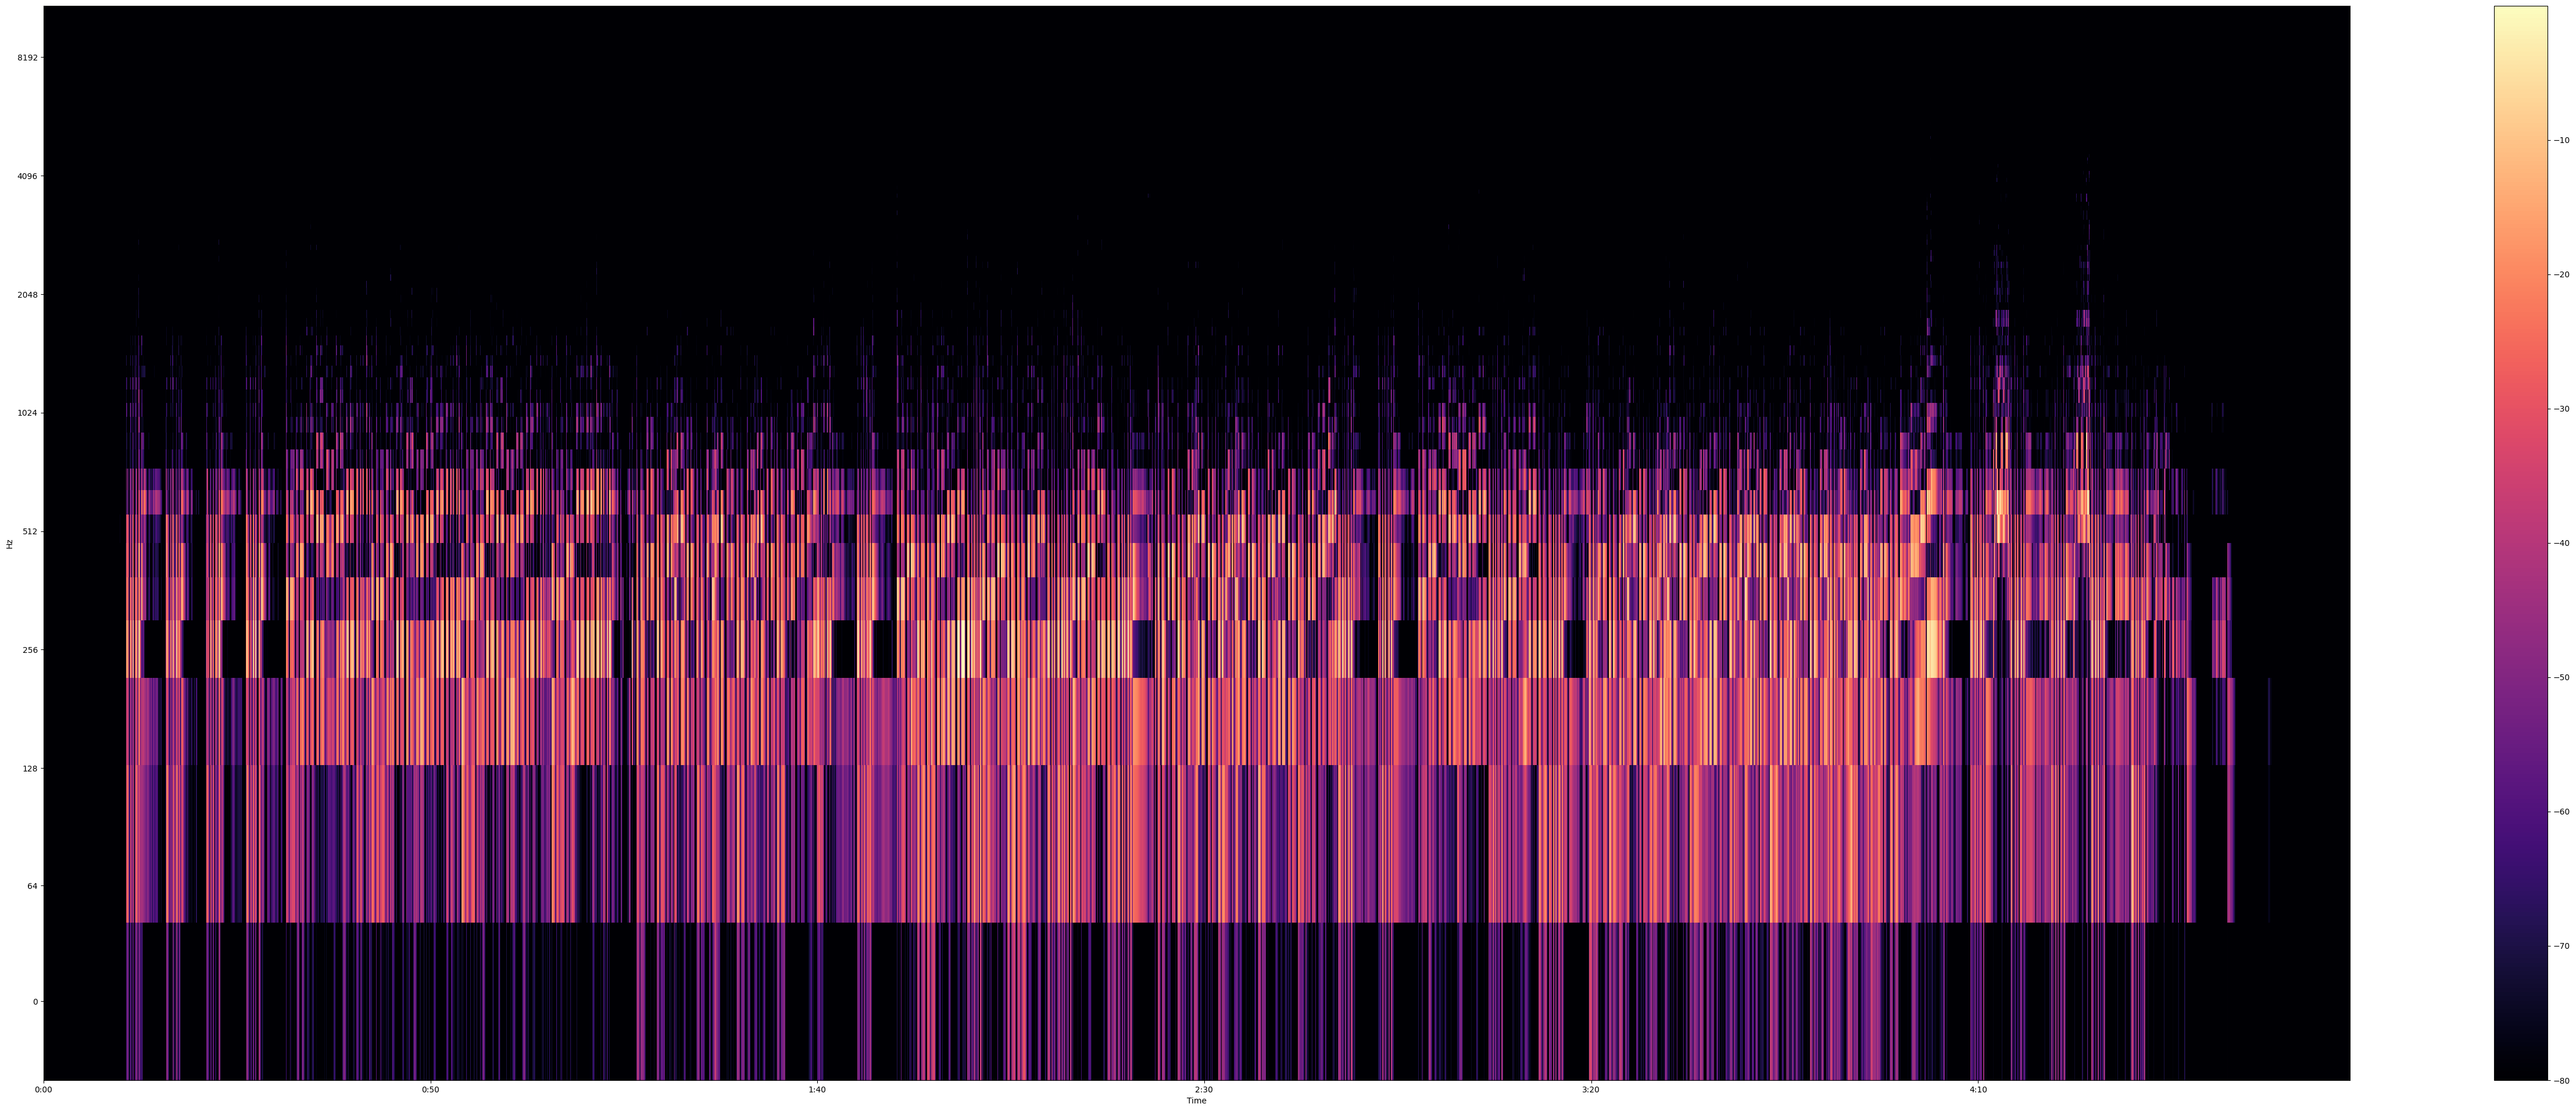

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(64, 24))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

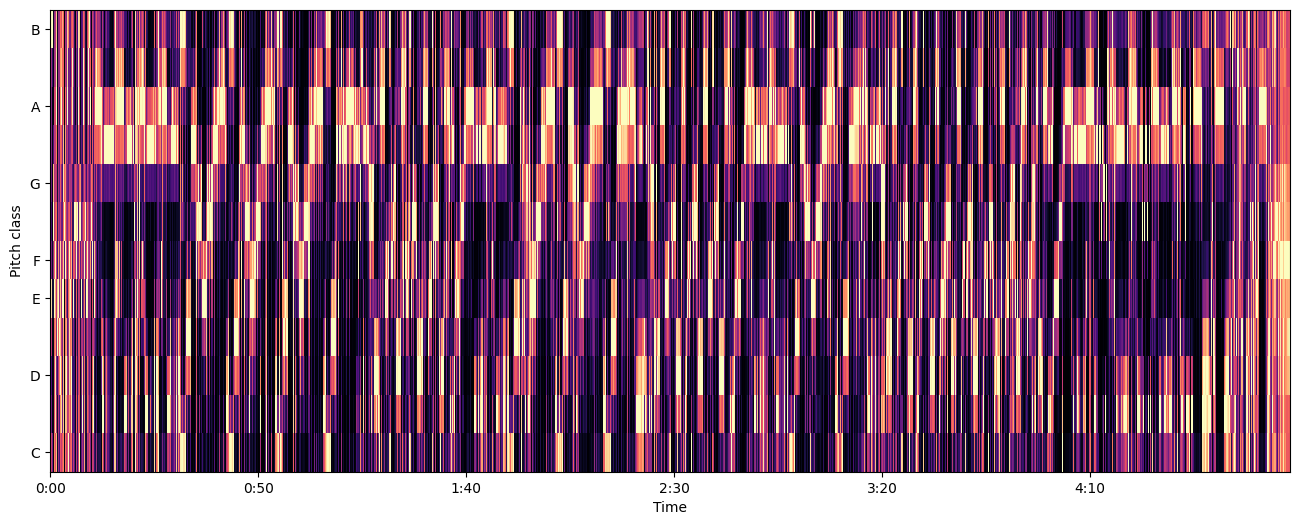

In [ ]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

#- check wav spectrogram (vocal stem)

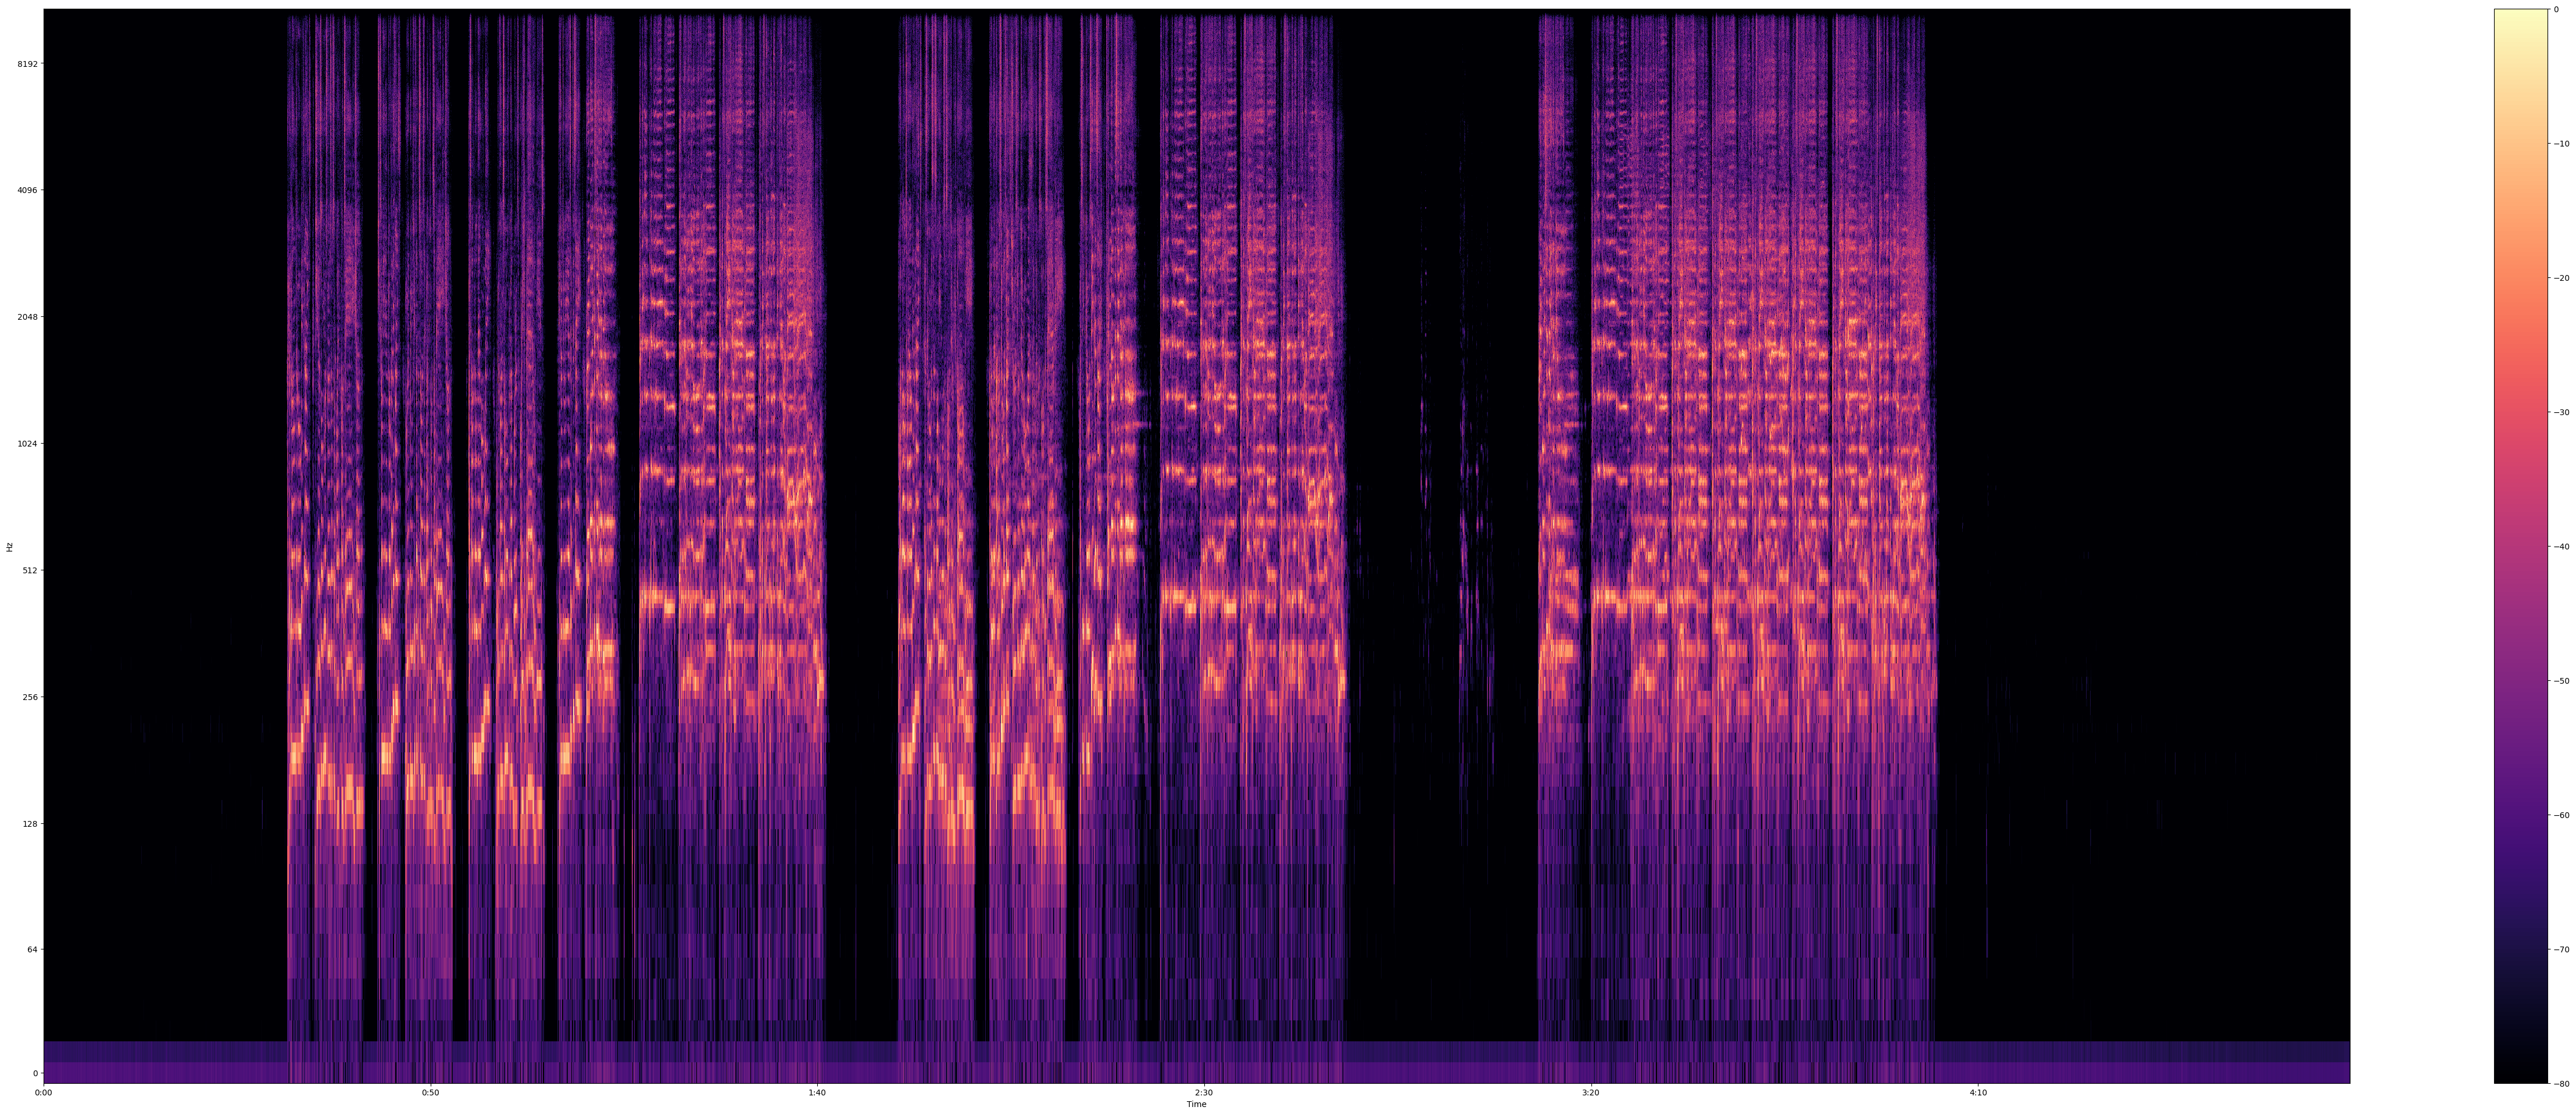

In [ ]:
y, sr = librosa.load("/content/drive/MyDrive/demucs_separated/mdx_extra/africa-toto/vocals.mp3")
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(64, 24))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

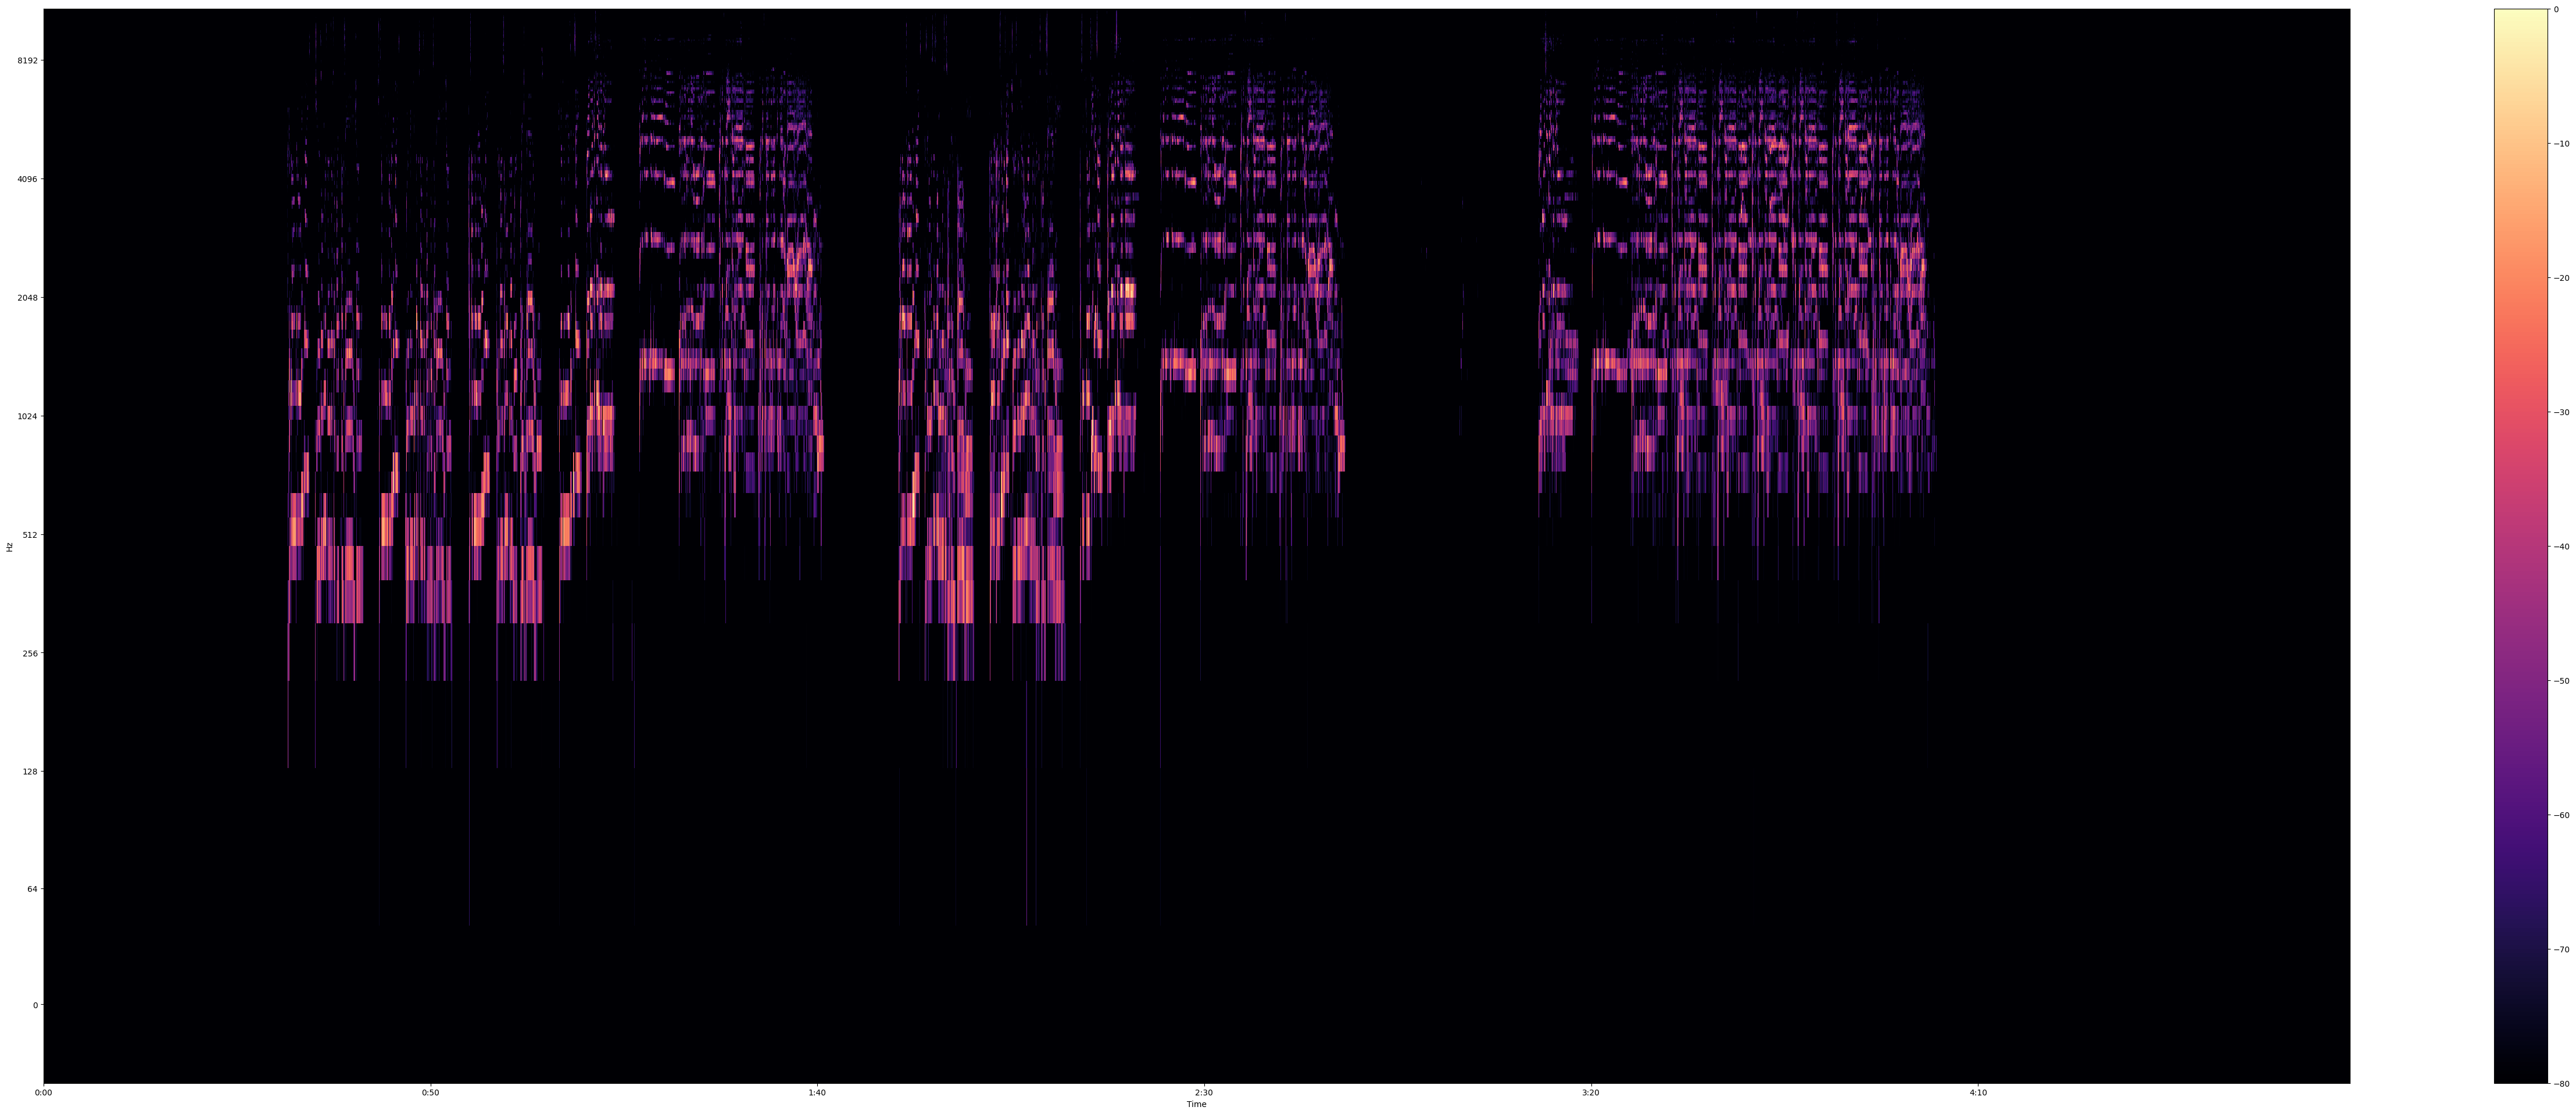

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(64, 24))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

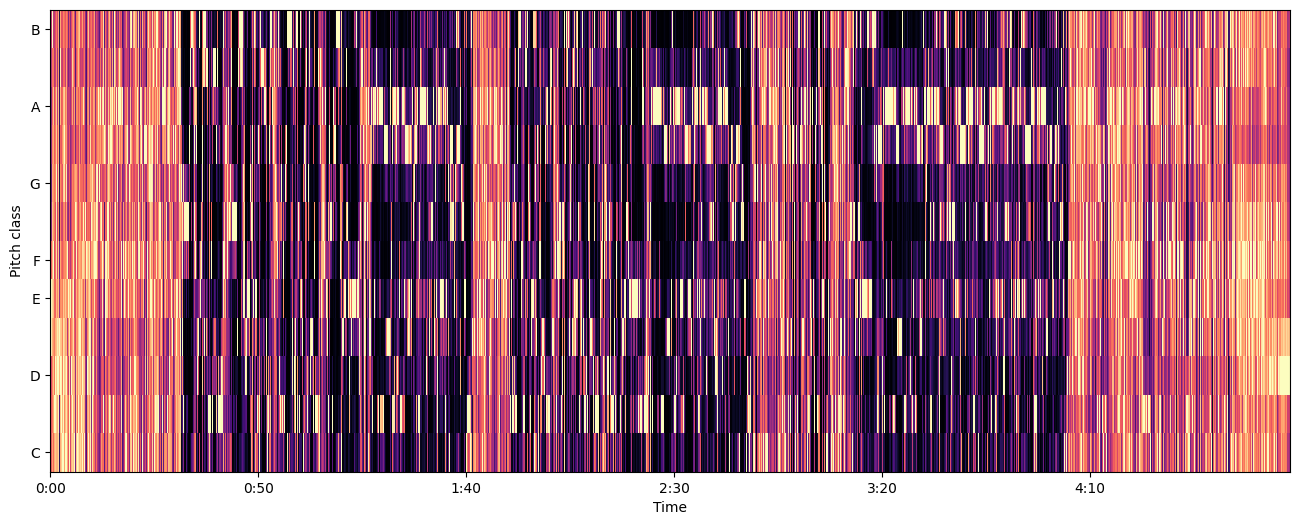

In [ ]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

# bass, vocal midi convert (test)

In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

In [ ]:
!pip install visual_midi
!pip install magenta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.6 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=2168e1df9b35b08422750fc18cd4e2097b30a48f0c4e5354ade12f428bd284ae
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9

In [ ]:
# For Python2.6 compatibility
from __future__ import print_function

import pretty_midi
import numpy as np
# For plotting
# import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display

from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

In [ ]:
# Load MIDI file into PrettyMIDI object
path = '/content/drive/MyDrive/audio_to_midi/vocals.mp3.mid'

pm = pretty_midi.PrettyMIDI(path)
# Print an empirical estimate of its global tempo
print(pm.estimate_tempo())
# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(pm.get_chroma()))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/audio_to_midi/vocals.mp3.mid'

In [ ]:
preset = Preset(plot_width=850)
plotter = Plotter(preset, plot_max_length_bar=4)
pm = PrettyMIDI(path)
plotter.show_notebook(pm)